# AI Supported Driver Pose Estimation

Faruk K. Doğan <br>
Ali M. Mazak <br>

Bu notebook, araç içi video görüntüsünde sürücünün direksiyonu kaç elle tuttuğunu ( no_hands, one_hand, two_hands) tespit eden entegre bir pipeline’ı uçtan uca göstermektedir.

Kullanılan ana bileşenler

- YOLOv11 (Ultralytics) – Direksiyon tespiti için tek sınıflı nesne tespit modeli. Verilen giriş görüntüsünde CNN, direksiyonun bounding box’unu ve güven skorunu verir.


- ViTPose – Sürücünün iskeletini ve özellikle bilek keypointlerini çıkarmak için kullanılan vision transformer tabanlı bir pose estimation modeli. Vücut eklemlerini 2 boyutlu koordinatlar ve confidencelar ile verir.

- Lineer Kalman Filtresi – Yolo ve Vitpose yalnızca belirli karelerde ölçüm üretiyor. Kalman filtresi, bu seyrek ve gürültülü ölçümleri kullanarak tespit edilen direksiyon bounding box'unu ve eklem noktalarını ölçüm alınmayan kareler için doldurur ve kararlı şekilde takip eder.

- Random Forest (scikit learn) – Direksiyon ve bilek geometrisini kullanarak no_hands / one_hand / two_hands sınıflandırmasını öğrenen klasik bir makine öğrenmesi algoritması.

- EMA (Exponential Moving Average) - Random Forest her kare için sınıflandırma olasılıklarını üretiyor. EMA bu olasılıkları zaman içinde üstel olarak yumuşatarak ani zıplamaları filtreler ve daha kararlı bir olasılık profili elde etmemizi sağlar.

- Histerezis -  EMA'ya destek olarak, bir state’e (örneğin two_hands) girmek ve o state’ten çıkmak için farklı eşikler kullanarak gereksiz ileri geri geçişleri engeller. Böylece modelin çıktısı ekranda daha stabil görünür ve kısa süreli kararsızlıklar state değişimi olarak yorumlanmaz.

---

## Ön Koşullar

Bu notebook’un sorunsuz çalışması için aşağıdaki dosyaların indirilmeleri ve Google Drive’da `MyDrive/datasets/` dizininde bulunmaları gerekir.  

1. YOLO direksiyon eğitimi:

   [aug_dataset.zip](https://drive.google.com/file/d/1W8KCoFD_0YDmzHipQ_kM0j2GFIL-ADIl/view?usp=sharing)

2. Random Forest dataseti:

   [rf_dataset.zip](https://drive.google.com/file/d/1aLDX1RM3qi8Y1p_g-gufPfEEoCoSCGPK/view?usp=sharing)

3. Araç içi video:

   [gA_1_s6_2019...mp4](https://drive.google.com/file/d/1_KUtv8MDxzmpufBR7B1smRg9X8_kSb82/view?usp=sharing)

Notebook bu videoyu işleyerek çıktı olarak /MyDrive/yolo_runs/ dizinde bir mp4 video üretecektir.

---

## Özet notebook akışı

1. Gerekli kütüphanelerin kurulumu.
2. Google Drive bağlantısı
3. Dataset ve video path’lerinin tanımlanması.
4. Yolo eğitim veri setinin hazırlanması.
5.  Direksiyon tespit modelinin eğitimi veya hazır ağırlığın yüklenmesi.
6. rf_dataset üzerinden geometrik özelliklerin çıkarılması ve random forest eğitimi.
7. Video üzerinde Yolo, Vitpose, Kalman filtresi ve random forest entegrasyonu.
---

Proje boyunca kullanacağımız temel kütüphaneleri kuruyoruz. YOLO tabanlı direksiyon tespiti için ultralytics ve görüntü işleme için opencv.



In [1]:
%pip install -q ultralytics opencv-python

import ultralytics
ultralytics.checks()


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Setup complete ✅ (12 CPUs, 167.1 GB RAM, 38.2/235.7 GB disk)


Datasetler ve video dosyası bu Drive dizini üzerinden okunacaktır. Yetkilendirme bağlantısında google hesabını seçip izin verilmesi gerekir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive üzerindeki dataset zip dosyalarının ve video dosyasının path’lerini tanımlıyoruz. Assert ile dosyanın var olup olmadığı kontrol edilir.

In [3]:
import os, zipfile

AUG_ZIP = "/content/drive/MyDrive/datasets/aug_dataset.zip"
RF_ZIP  = "/content/drive/MyDrive/datasets/rf_dataset.zip"
DMD_VIDEO = "/content/drive/MyDrive/datasets/gA_1_s6_2019-03-22T11;59;56+01;00_rgb_body.mp4"

assert os.path.exists(AUG_ZIP)
assert os.path.exists(RF_ZIP)
assert os.path.exists(DMD_VIDEO)

Yolo direksiyon eğitim datasetinin hazırlanmalıdır. Zip dosyası açılır ve gerekli .yaml dosyası ayarlanır.

In [4]:
AUG_DIR = "/content/aug_dataset"

if not os.path.isdir(AUG_DIR):
    with zipfile.ZipFile(AUG_ZIP, "r") as zf:
        zf.extractall("/content")
assert os.path.exists(os.path.join(AUG_DIR, "data.yaml"))

DATA_YAML = "/content/aug_dataset/data.yaml"

Bu hücrede yolo direksiyon tespit modelini hazırlıyoruz. Eğer daha önce eğitilmiş ağırlıklar varsa doğrudan yüklüyoruz, yoksa aug_dataset üzerindeki data.yaml ile yolo11n.pt modelini 25 epoch fine tune edip ağırlıkları drive'a kaydediyoruz.


In [5]:
from ultralytics import YOLO
import os

RUNS_DIR = "/content/drive/MyDrive/yolo_runs"
RUN_NAME = "yolo11n_steering"
RUN_DIR = f"{RUNS_DIR}/{RUN_NAME}"
BEST_WEIGHTS = f"{RUN_DIR}/weights/best.pt"

print("RUN_DIR:", RUN_DIR)
print("BEST_WEIGHTS:", BEST_WEIGHTS)

if os.path.exists(BEST_WEIGHTS):
    print("best.pt found, loading trained YOLO model...")
    model = YOLO(BEST_WEIGHTS)
else:
    print("best.pt not found, starting YOLO training...")

    model = YOLO("yolo11n.pt")
    print("Training from pretrained yolo11n.pt...")

    results = model.train(
        data=DATA_YAML,
        epochs=25,
        imgsz=640,
        project=RUNS_DIR,
        name=RUN_NAME,
        exist_ok=True,
    )
    print("Training finished. Results saved to:", RUN_DIR)

    if os.path.exists(BEST_WEIGHTS):
        print("best.pt found after training, reloading:", BEST_WEIGHTS)
        model = YOLO(BEST_WEIGHTS)
    else:
        print("Warning: training finished but BEST_WEIGHTS not found:", BEST_WEIGHTS)


RUN_DIR: /content/drive/MyDrive/yolo_runs/yolo11n_steering
BEST_WEIGHTS: /content/drive/MyDrive/yolo_runs/yolo11n_steering/weights/best.pt
best.pt not found, starting YOLO training...
Training from pretrained yolo11n.pt...
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/aug_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det

YOLO direksiyon modelinin eğitim özetini görmek için Ultralytics'in ürettiği results.png grafiğini görüntülüyoruz.  

results.png path: /content/drive/MyDrive/yolo_runs/yolo11n_steering/results.png


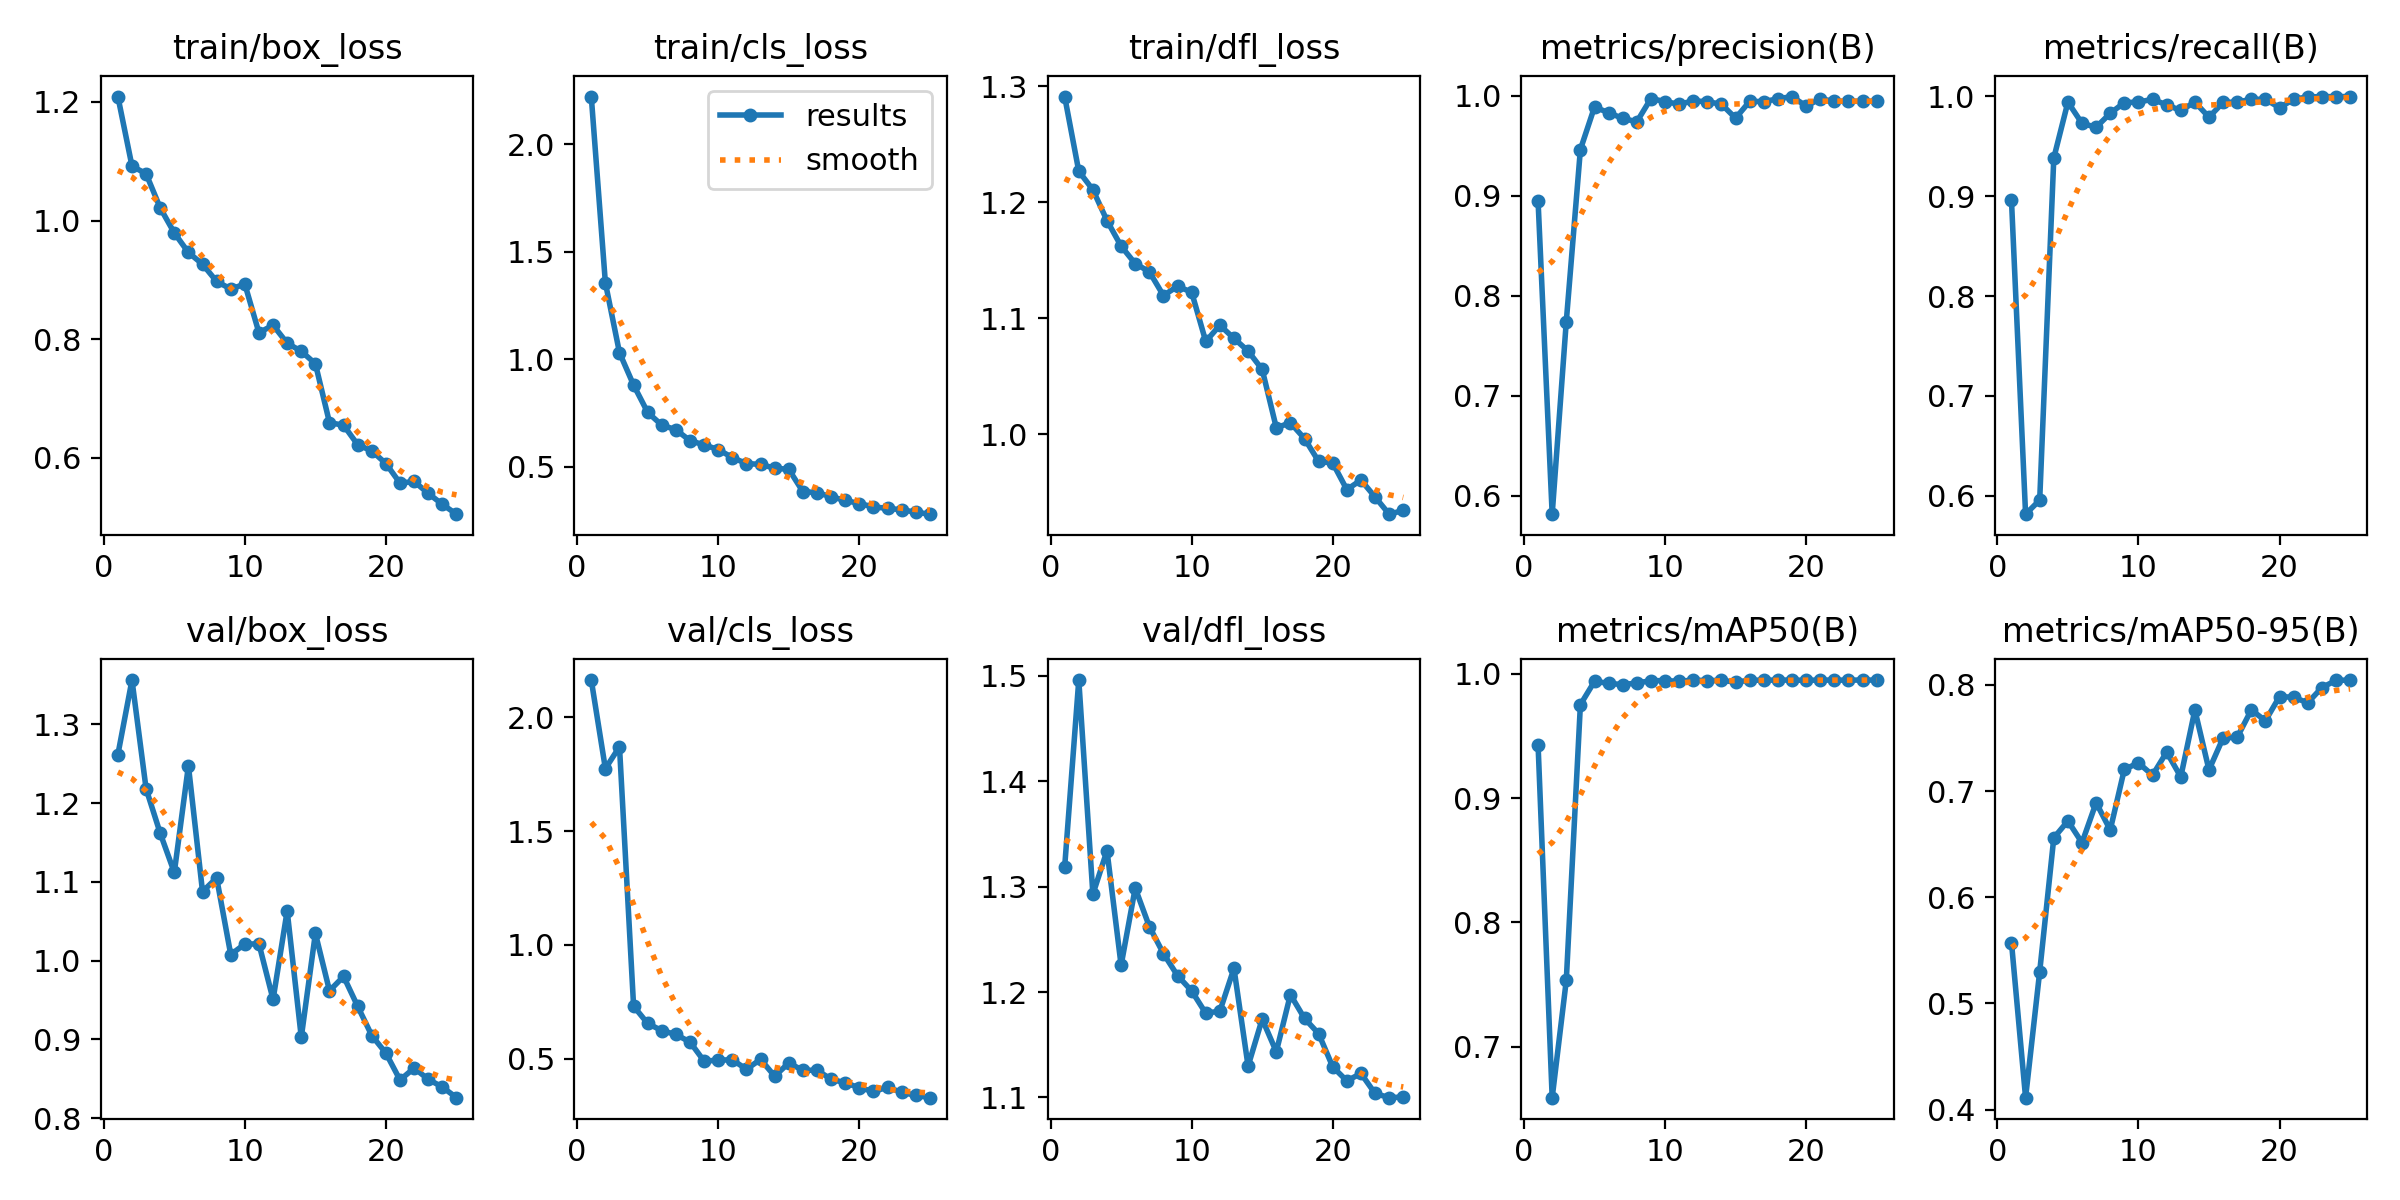

In [6]:
from IPython.display import Image, display
import os

RUNS_DIR = "/content/drive/MyDrive/yolo_runs"
RUN_NAME = "yolo11n_steering"
RUN_DIR = f"{RUNS_DIR}/{RUN_NAME}"

RESULTS_PNG = f"{RUN_DIR}/results.png"
print("results.png path:", RESULTS_PNG)
display(Image(filename=RESULTS_PNG, width=800))

Yolo direksiyon modelinin validation çıktısı için confusion matrix'i gösteriyoruz.  Bu model tek sınıflı olduğu için bu confusion matrix, aslında klasik anlamda sınıflar arası karışıklığı değil, modelin kutu çizip çizmeme davranışını değerlendirmek için kullanılır.


Confusion matrix path: /content/drive/MyDrive/yolo_runs/yolo11n_steering/confusion_matrix.png


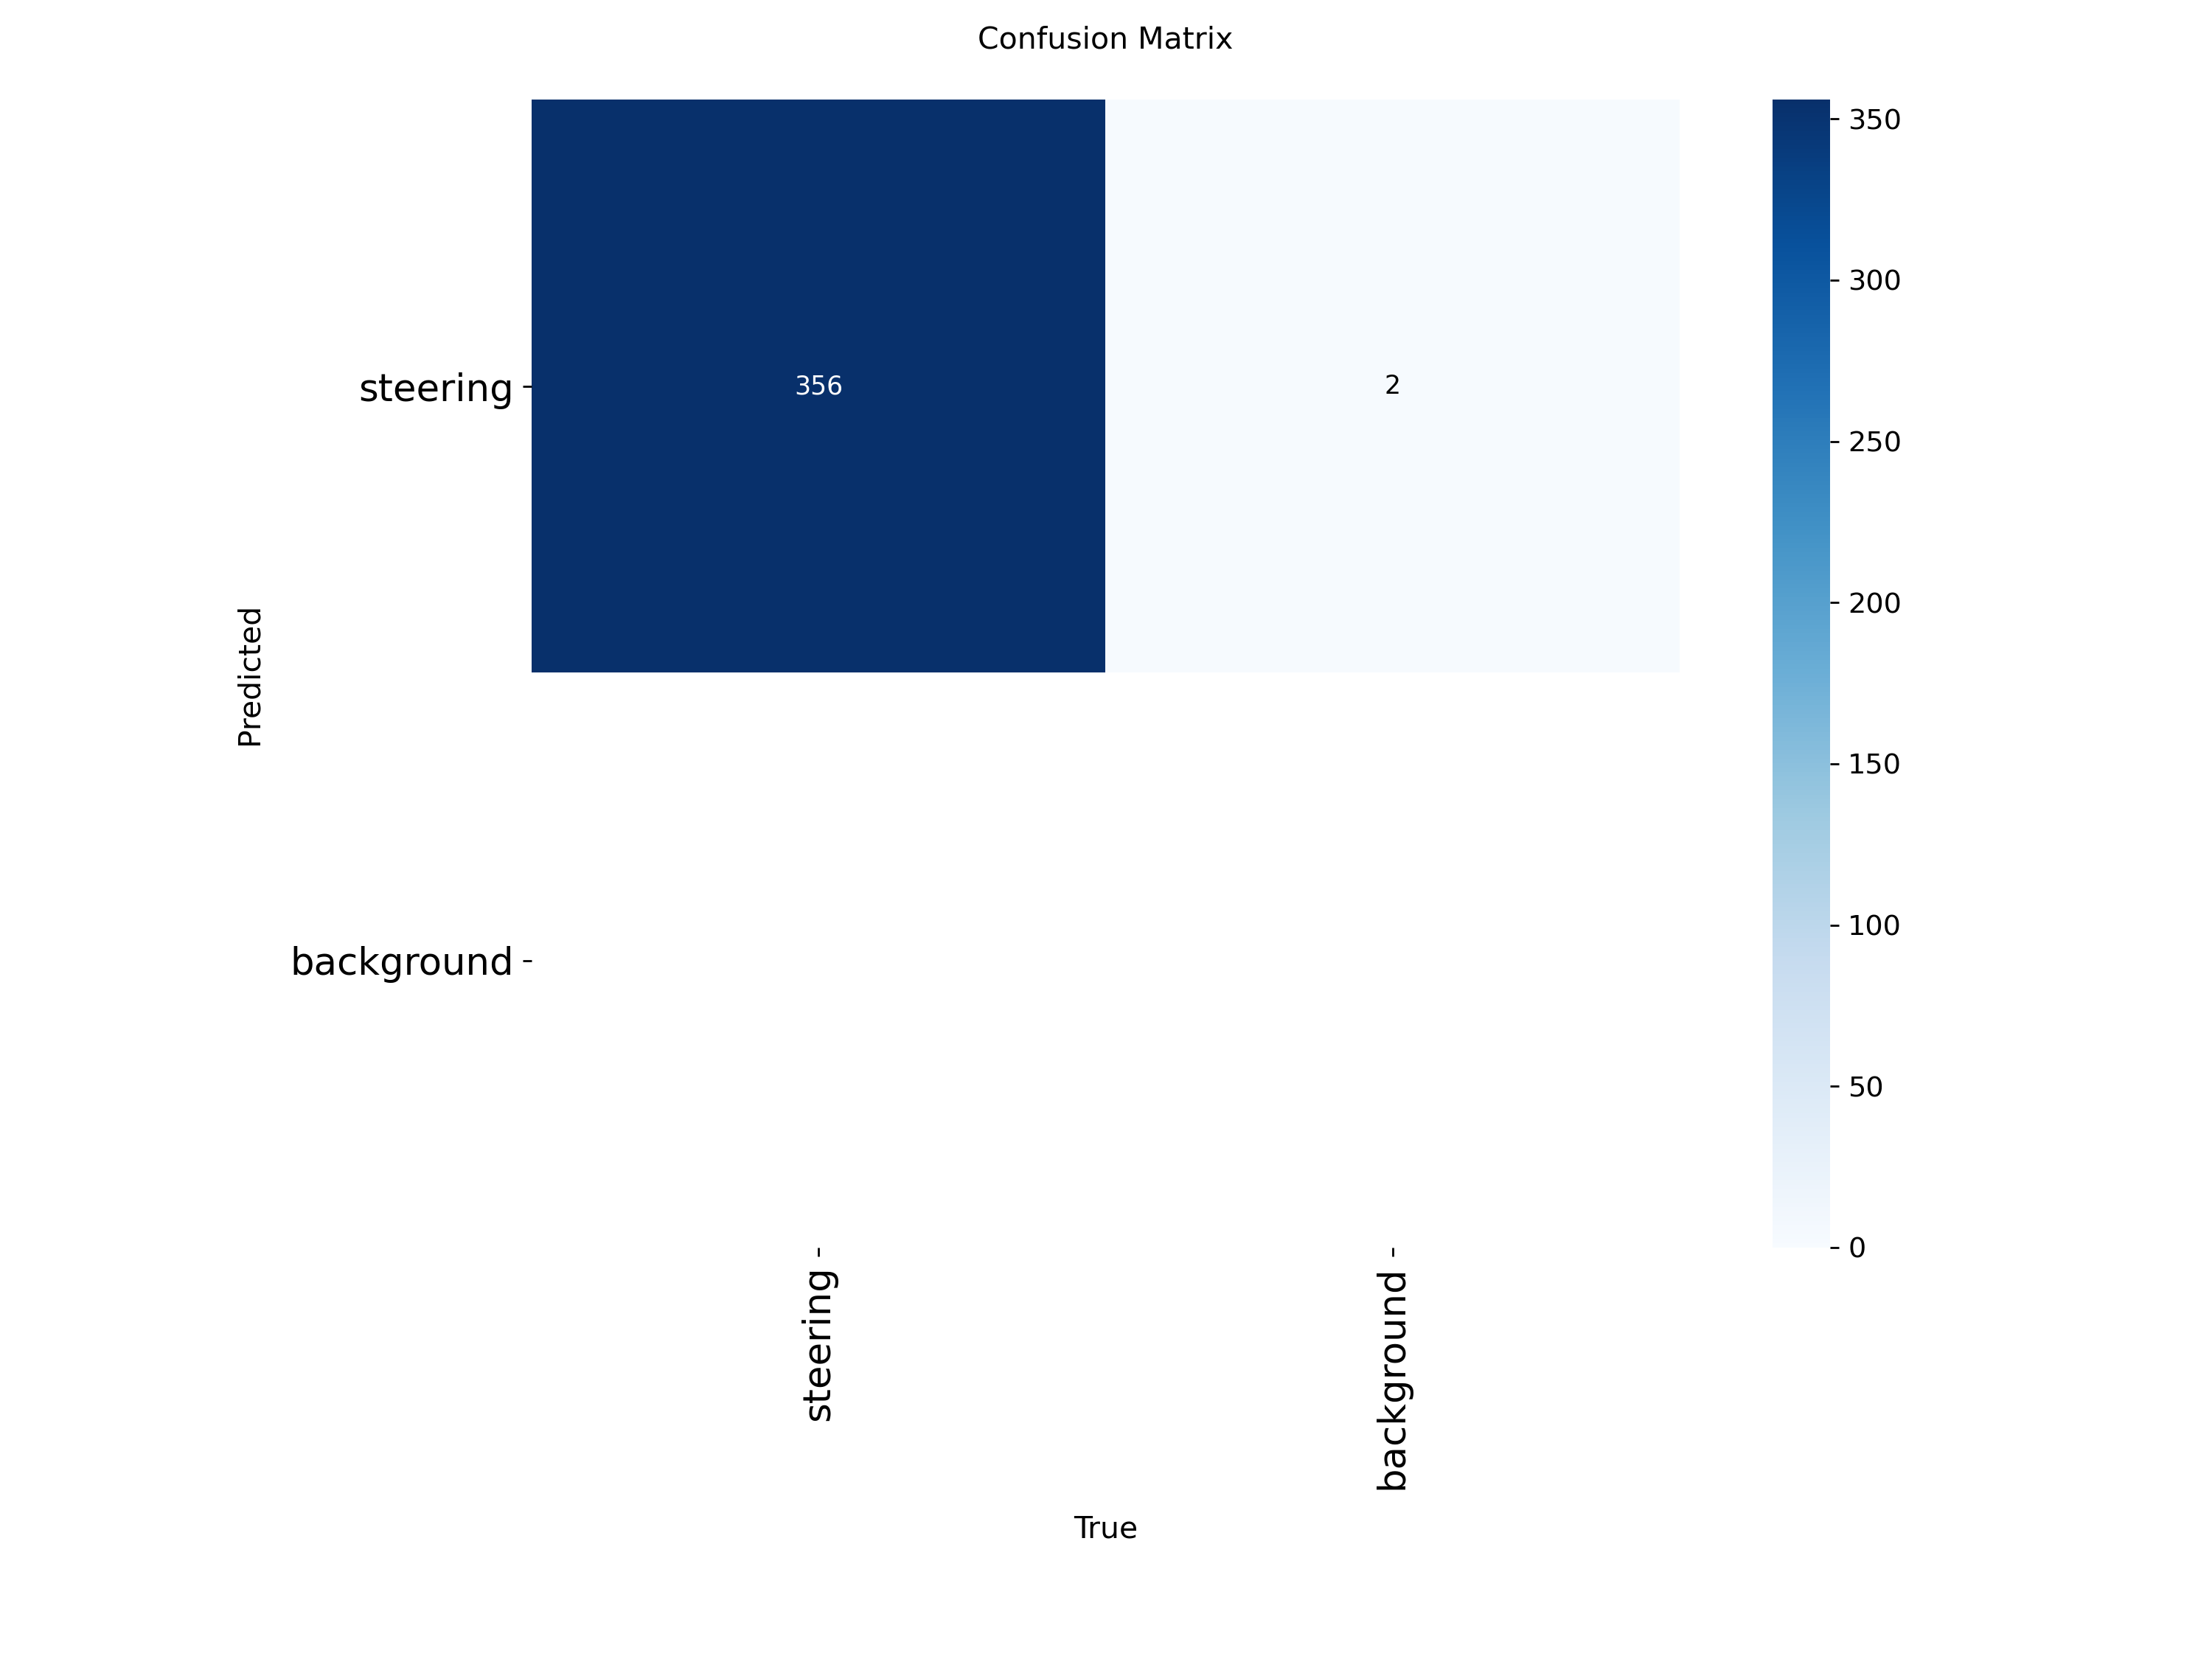

In [7]:
from IPython.display import Image, display
import os

RUNS_DIR = "/content/drive/MyDrive/yolo_runs"
RUN_NAME = "yolo11n_steering"
RUN_DIR = f"{RUNS_DIR}/{RUN_NAME}"

CM_PNG = f"{RUN_DIR}/confusion_matrix.png"

print("Confusion matrix path:", CM_PNG)
display(Image(filename=CM_PNG, width=500))

ViTPose için gerekli paketleri kurup pretrained pose modelini yüklüyoruz.  
Transformers üzerinden `usyd-community/vitpose-base-simple` modeli indiriliyor ve COCO 17 keypoint için pose processor + model hazır hale geliyor.


In [8]:
%pip install -q "transformers>=4.49.0" accelerate safetensors

import torch
from transformers import AutoProcessor, VitPoseForPoseEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

VITPOSE_MODEL_ID = "usyd-community/vitpose-base-simple"

pose_processor = AutoProcessor.from_pretrained(VITPOSE_MODEL_ID)
pose_model = VitPoseForPoseEstimation.from_pretrained(VITPOSE_MODEL_ID).to(device)

print("Loaded ViTPose model:", VITPOSE_MODEL_ID)

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

Loaded ViTPose model: usyd-community/vitpose-base-simple


rf_dataset içindeki etiketli statik görüntüleri kullanarak Random Forest modelini eğitiyoruz. Amaç her görüntü için direksiyon ve bilek geometrisini sayısal bir feature vektörüne çevirip hand_state (no_hands, one_hand, two_hands) sınıfını öğrenmek.

Önce rf_dataset.zip açılıyor, rf_labels_all.csv okunuyor ve her satır için gerçek görüntü pathi (image_path_fixed) Colab’e göre düzeltiliyor. Ardından yolo ve Vitpose ağırlıkları yükleniyor. Böylece her görüntüde direksiyon bounding box'u ve bilek noktalarını tespit edebiliyoruz.

Her görüntü için bazı özellikleri çıkarıyoruz.  
Direksiyon merkezini $c_x, c_y$, genişlik ve yüksekliğini $w, h$ alıyoruz. Direksiyon yarıçapını:

$$ r = \frac{1}{2} \min(w, h) $$

olarak tanımlıyoruz. Sol bileğin $(x_L, y_L)$, sağ bileğin $(x_R, y_R)$ koordinatları için direksiyon merkezine uzaklıklarını

$$ d_L = \frac{\sqrt{(x_L - c_x)^2 + (y_L - c_y)^2}}{r}, \quad
   d_R = \frac{\sqrt{(x_R - c_x)^2 + (y_R - c_y)^2}}{r} $$

olarak hesaplıyoruz. Ayrıca bunlardan türev featurelar üretiyoruz :

 $\min(d_L, d_R)$, $\max(d_L, d_R)$ ve $|d_L - d_R|$.  

Ek olarak bileğin direksiyon çevresinde olup olmadığını gösteren bayraklar tanımlıyoruz:
$$ \text{onL} = [d_L \le 1 + \text{margin}], \quad
   \text{onR} = [d_R \le 1 + \text{margin}] $$
Burada margin = ONWHEEL_MARGIN. Direksiyon alanını normalize ediyoruz:

$$ \text{wheel_area_norm} = \frac{w \cdot h}{W \cdot H} $$

$W$ ve $H$ görüntü boyutlarını temsil ediyor. Ayrıca YOLO direksiyon skoru wheel_conf ve ViTPose bilek skorları (lw_score, rw_score) da feature set’e ekleniyor.

Bu özellikler ilk çalıştırmada tüm görüntüler için hesaplanıp rf_features_cache.csv dosyasına yazılıyor. Sonraki çalıştırmalarda doğrudan cache’ten okunuyor. Böylece YOLO ve ViTPose her seferinde yeniden çağrılmıyor. Ardından $X$ (feature matrisi) ve $y$ (etiket vektörü) hazırlanıyor, train/test ayrımı yapılıyor ve RandomForestClassifier modeli eğitiliyor.

Son kısımda model test seti üzerinde değerlendirilip classification report, sayısal ve normalize confusion matrix ve feature importance grafiği çizdiriliyor. Hücre sonunda eğitilmiş RF modeli rf_hands_randomforest.pkl ve kullanılan feature-metrik bilgileri (rf_hands_feature_meta.json) Drive’a kaydediliyor. Bu model daha sonra video üzerinde frame bazlı no_hands,one_hand,two_hands tahmini yapmak için kullanılacak.


Device: cuda | DTYPE: torch.float16
Unzipping rf_dataset.zip ...
Loading YOLO and ViTPose...
Total rows in CSV (existing files): 303
hand_state
one_hand     159
two_hands     82
no_hands      62
Name: count, dtype: int64


Extracting features: 100%|██████████| 303/303 [00:13<00:00, 22.78it/s]


Features saved to cache: /content/rf_dataset/rf_features_cache.csv, n=303
Feature extraction time: 13.3s
Also copied cache to: /content/drive/MyDrive/yolo_runs/rf_models/rf_features_cache.csv
Wheel found rate: 100.0%
L_det rate: 100.0% | R_det rate: 100.0%

== Classification report ==
              precision    recall  f1-score   support

    no_hands      0.923     1.000     0.960        12
    one_hand      1.000     0.938     0.968        32
   two_hands      0.944     1.000     0.971        17

    accuracy                          0.967        61
   macro avg      0.956     0.979     0.966        61
weighted avg      0.969     0.967     0.967        61



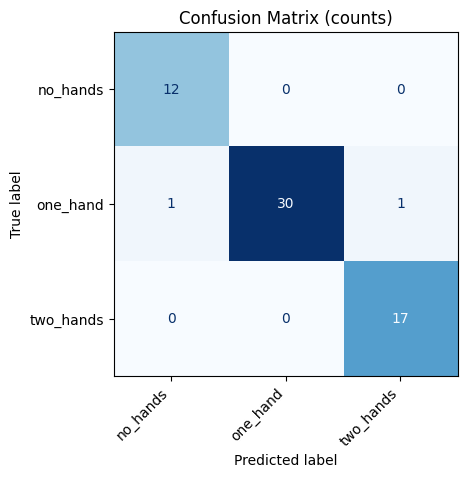

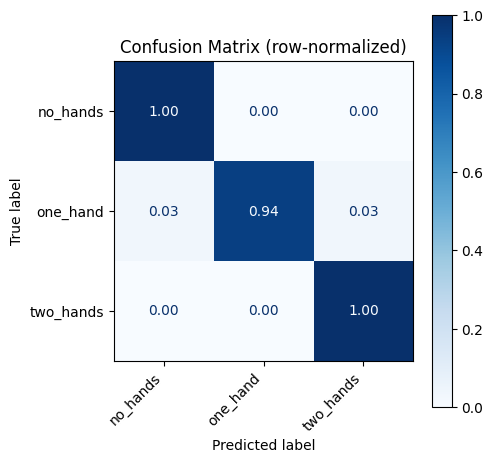

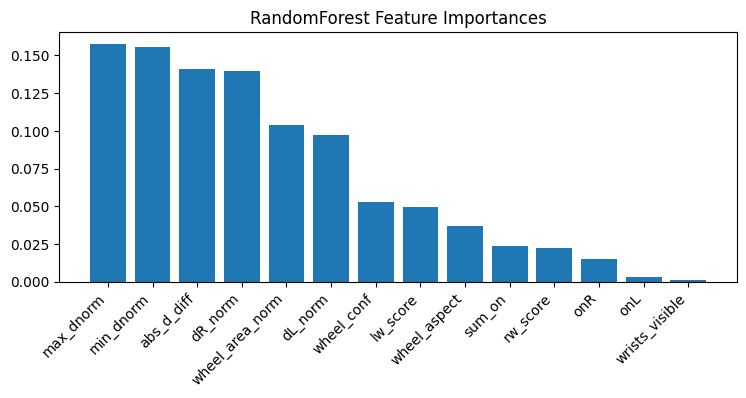






Saved model: /content/drive/MyDrive/yolo_runs/rf_models/rf_hands_randomforest.pkl
Saved meta:  /content/drive/MyDrive/yolo_runs/rf_models/rf_hands_feature_meta.json
Cache CSV:   /content/rf_dataset/rf_features_cache.csv


In [9]:
import os, zipfile, contextlib, math, json, pickle, warnings, time, shutil, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import torch
from PIL import Image
from ultralytics import YOLO
from transformers import AutoProcessor, VitPoseForPoseEstimation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

RF_ZIP = "/content/drive/MyDrive/datasets/rf_dataset.zip"
RF_DIR = "/content/rf_dataset"
IMAGES_DIR = f"{RF_DIR}/images"
CSV_PATH   = f"{RF_DIR}/rf_labels_all.csv"

BEST_WEIGHTS      = "/content/drive/MyDrive/yolo_runs/yolo11n_steering/weights/best.pt"
VITPOSE_MODEL_ID  = "usyd-community/vitpose-base-simple"

YOLO_CONF_TH      = 0.25
KPT_SCORE_VIS_TH  = 0.15
ONWHEEL_MARGIN    = 0.15

FEAT_CACHE_CSV = f"{RF_DIR}/rf_features_cache.csv"
FEAT_CACHE_CSV_DRIVE = "/content/drive/MyDrive/yolo_runs/rf_models/rf_features_cache.csv"

MODEL_DIR  = "/content/drive/MyDrive/yolo_runs/rf_models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = f"{MODEL_DIR}/rf_hands_randomforest.pkl"
META_PATH  = f"{MODEL_DIR}/rf_hands_feature_meta.json"

USE_GPU = torch.cuda.is_available()
DEVICE  = "cuda" if USE_GPU else "cpu"
DTYPE   = torch.float16 if USE_GPU else torch.float32
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_GPU else contextlib.nullcontext()

np.random.seed(42)
random.seed(42)

print(f"Device: {DEVICE} | DTYPE: {DTYPE}")

try:
    _ = os.listdir("/content/drive")
except Exception:
    from google.colab import drive
    drive.mount('/content/drive')

if not os.path.isdir(RF_DIR):
    assert os.path.isfile(RF_ZIP), f"Zip not found: {RF_ZIP}"
    print("Unzipping rf_dataset.zip ...")
    with zipfile.ZipFile(RF_ZIP, 'r') as zf:
        zf.extractall("/content")
    if not os.path.isdir(RF_DIR) or not os.path.isdir(IMAGES_DIR) or not os.path.isfile(CSV_PATH):
        guess_dir = None
        for root, dirs, files in os.walk("/content"):
            if "rf_labels_all.csv" in files and "images" in dirs:
                guess_dir = root
                break
        assert guess_dir is not None, "rf_dataset structure not found after unzip."
        RF_DIR = guess_dir
        IMAGES_DIR = f"{RF_DIR}/images"
        CSV_PATH   = f"{RF_DIR}/rf_labels_all.csv"
        print("Detected RF_DIR:", RF_DIR)

assert os.path.isdir(IMAGES_DIR), f"images/ not found under: {RF_DIR}"
assert os.path.isfile(CSV_PATH), f"CSV not found: {CSV_PATH}"

print("Loading YOLO and ViTPose...")
yolo = YOLO(BEST_WEIGHTS)

pose_processor = AutoProcessor.from_pretrained(VITPOSE_MODEL_ID, use_fast=False)
try:
    pose_model = VitPoseForPoseEstimation.from_pretrained(VITPOSE_MODEL_ID, dtype=DTYPE).to(DEVICE)
except TypeError:
    pose_model = VitPoseForPoseEstimation.from_pretrained(VITPOSE_MODEL_ID, torch_dtype=DTYPE).to(DEVICE)
pose_model.eval()

LEFT_WRIST_IDX, RIGHT_WRIST_IDX = 9, 10

def ensure_path_on_colab(original_path: str) -> str:
    fname = os.path.basename(original_path)
    p = os.path.join(IMAGES_DIR, fname)
    return p if os.path.isfile(p) else original_path

def run_yolo_wheel(img_bgr):
    res = yolo(img_bgr, imgsz=640, conf=YOLO_CONF_TH, verbose=False, device=0 if DEVICE=="cuda" else None)[0]
    if res.boxes is None or len(res.boxes) == 0:
        return None
    xyxy = res.boxes.xyxy.cpu().numpy()
    conf = res.boxes.conf.cpu().numpy()
    i = int(np.argmax(conf))
    x1,y1,x2,y2 = xyxy[i].astype(float)
    cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
    w, h  = max(x2-x1, 1.0), max(y2-y1, 1.0)
    return (cx, cy, w, h, float(conf[i]))

def run_vitpose_keypoints(img_rgb):
    H, W, _ = img_rgb.shape
    boxes = np.array([[0,0,W,H]], dtype=np.float32)
    inputs = pose_processor(Image.fromarray(img_rgb), boxes=[boxes], return_tensors="pt").to(DEVICE)

    with torch.inference_mode(), amp_ctx:
        outputs = pose_model(**inputs)

    if hasattr(outputs, "heatmaps"):
        outputs.heatmaps = outputs.heatmaps.float()
    else:
        for k,v in outputs.items():
            if torch.is_tensor(v):
                outputs[k] = v.float()

    results = pose_processor.post_process_pose_estimation(outputs, boxes=[boxes])
    if len(results[0]) == 0:
        return None
    out0 = results[0][0]
    kp = out0["keypoints"].detach().cpu().numpy()
    sc = out0["scores"].detach().cpu().numpy()
    return kp, sc

def extract_features_one(img_path):
    if not os.path.isfile(img_path):
        return None

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        return None
    H, W = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    wheel = run_yolo_wheel(img_bgr)
    wheel_found = 1 if wheel is not None else 0

    if wheel is None:
        cx = W/2.0
        cy = H/2.0
        w = h = 1.0
        wconf = 0.0
        r = 1e-6
    else:
        cx, cy, w, h, wconf = wheel
        r = 0.5*min(w, h) if min(w,h) > 1e-3 else 1.0

    pose = run_vitpose_keypoints(img_rgb)
    if pose is None:
        kp = np.full((17,2), np.nan, dtype=np.float32)
        sc = np.zeros((17,), dtype=np.float32)
    else:
        kp, sc = pose

    lw = kp[LEFT_WRIST_IDX] if not np.isnan(kp[LEFT_WRIST_IDX]).any() else None
    rw = kp[RIGHT_WRIST_IDX] if not np.isnan(kp[RIGHT_WRIST_IDX]).any() else None
    lw_s = float(sc[LEFT_WRIST_IDX]) if not np.isnan(sc[LEFT_WRIST_IDX]) else 0.0
    rw_s = float(sc[RIGHT_WRIST_IDX]) if not np.isnan(sc[RIGHT_WRIST_IDX]) else 0.0

    def dnorm(pt):
        if pt is None or r < 1e-5:
            return 10.0
        return float(np.hypot(pt[0]-cx, pt[1]-cy) / r)

    dL = dnorm(lw)
    dR = dnorm(rw)

    onL = int(dL <= 1.0 + ONWHEEL_MARGIN)
    onR = int(dR <= 1.0 + ONWHEEL_MARGIN)

    wheel_area_norm = float((w*h) / (W*H))
    wheel_aspect    = float(w / max(h,1e-6))
    wrists_vis      = int(lw_s > KPT_SCORE_VIS_TH) + int(rw_s > KPT_SCORE_VIS_TH)

    feats = {
        "dL_norm": dL,
        "dR_norm": dR,
        "min_dnorm": float(min(dL, dR)),
        "max_dnorm": float(max(dL, dR)),
        "abs_d_diff": float(abs(dL - dR)),
        "onL": onL,
        "onR": onR,
        "sum_on": int(onL + onR),
        "wrists_visible": wrists_vis,
        "lw_score": lw_s,
        "rw_score": rw_s,
        "wheel_conf": float(wconf),
        "wheel_area_norm": wheel_area_norm,
        "wheel_aspect": wheel_aspect,
        "wheel_found": wheel_found,
        "L_det": int(lw is not None),
        "R_det": int(rw is not None),
        "image_path_fixed": img_path
    }
    return feats

df = pd.read_csv(CSV_PATH)
assert "image_path" in df.columns and "hand_state" in df.columns, "CSV must have columns: image_path, hand_state"

dup = (df["image_path"].apply(os.path.basename).value_counts())
dup = dup[dup > 1]
if len(dup):
    print("WARNING: duplicate basenames found in CSV. Will map by basename; duplicates may be ambiguous.")
    print(dup.head())

df["image_path_fixed"] = df["image_path"].map(ensure_path_on_colab)
df = df[df["image_path_fixed"].apply(lambda p: os.path.isfile(p))].reset_index(drop=True)

print("Total rows in CSV (existing files):", len(df))
print(df["hand_state"].value_counts())

start_t = time.time()
if os.path.isfile(FEAT_CACHE_CSV):
    feats_df = pd.read_csv(FEAT_CACHE_CSV)
    feats_df = feats_df[feats_df["image_path_fixed"].isin(df["image_path_fixed"])].reset_index(drop=True)
    if "hand_state" not in feats_df.columns:
        feats_df = feats_df.merge(df[["image_path_fixed","hand_state"]], on="image_path_fixed", how="left")
    print(f"Loaded feature cache: {len(feats_df)} rows")
else:
    rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        img_path = row["image_path_fixed"]
        f = extract_features_one(img_path)
        if f is None:
            continue
        rows.append(f)
    feats_df = pd.DataFrame(rows)
    feats_df = feats_df.merge(df[["image_path_fixed","hand_state"]], on="image_path_fixed", how="inner")
    feats_df.to_csv(FEAT_CACHE_CSV, index=False)
    print(f"Features saved to cache: {FEAT_CACHE_CSV}, n={len(feats_df)}")
print(f"Feature extraction time: {time.time()-start_t:.1f}s")

try:
    shutil.copy2(FEAT_CACHE_CSV, FEAT_CACHE_CSV_DRIVE)
    print("Also copied cache to:", FEAT_CACHE_CSV_DRIVE)
except Exception as e:
    print("Cache copy to Drive skipped:", e)

FEATURES = [
    "dL_norm","dR_norm","min_dnorm","max_dnorm","abs_d_diff",
    "onL","onR","sum_on","wrists_visible",
    "lw_score","rw_score",
    "wheel_conf","wheel_area_norm","wheel_aspect"
]

needed_cols = set(FEATURES + ["hand_state","image_path_fixed"])
for c in needed_cols:
    if c not in feats_df.columns:
        feats_df[c] = np.nan

feats_df[FEATURES] = feats_df[FEATURES].fillna({
    "dL_norm":10.0,
    "dR_norm":10.0,
    "min_dnorm":10.0,
    "max_dnorm":10.0,
    "abs_d_diff":0.0,
    "onL":0,
    "onR":0,
    "sum_on":0,
    "wrists_visible":0,
    "lw_score":0.0,
    "rw_score":0.0,
    "wheel_conf":0.0,
    "wheel_area_norm":0.0,
    "wheel_aspect":1.0
})

if "wheel_found" in feats_df.columns:
    wf_rate = feats_df["wheel_found"].mean()
    print(f"Wheel found rate: {wf_rate*100:.1f}%")
if "L_det" in feats_df.columns and "R_det" in feats_df.columns:
    print(f"L_det rate: {feats_df['L_det'].mean()*100:.1f}% | R_det rate: {feats_df['R_det'].mean()*100:.1f}%")

X = feats_df[FEATURES].values.astype(np.float32)
y_labels = feats_df["hand_state"].values
class_names = sorted(pd.unique(y_labels).tolist())
label_to_id = {c:i for i,c in enumerate(class_names)}
id_to_label = {i:c for c,i in label_to_id.items()}
y = np.array([label_to_id[s] for s in y_labels], dtype=int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("\n== Classification report ==")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=list(range(len(class_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5.2, 5.0))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (counts)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(pad=1.5)
plt.show(); print("\n"*3)

cm_norm = confusion_matrix(y_test, y_pred, labels=list(range(len(class_names))), normalize="true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5.2, 5.0))
disp2.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Confusion Matrix (row-normalized)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(pad=1.5)
plt.show(); print("\n"*3)

importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
plt.figure(figsize=(7.6,4.2))
plt.bar(range(len(FEATURES)), importances[order])
plt.xticks(range(len(FEATURES)), [FEATURES[i] for i in order], rotation=45, ha="right")
plt.title("RandomForest Feature Importances")
plt.tight_layout(pad=1.5)
plt.show(); print("\n"*3)

with open(MODEL_PATH, "wb") as f:
    pickle.dump(rf, f)

meta = {
    "features": FEATURES,
    "class_names": class_names,
    "label_to_id": label_to_id,
    "id_to_label": id_to_label,
    "yolo_conf_th": YOLO_CONF_TH,
    "kpt_score_vis_th": KPT_SCORE_VIS_TH,
    "onwheel_margin": ONWHEEL_MARGIN,
    "vitpose_model": VITPOSE_MODEL_ID,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print("\nSaved model:", MODEL_PATH)
print("Saved meta: ", META_PATH)
print("Cache CSV:  ", FEAT_CACHE_CSV)


## Video üzerinde tam entegrasyon

Bu hücrede, YOLO (direksiyon), ViTPose (iskelet) ve iki Kalman filtresini (direksiyon bounding box + 17 eklem noktası) tek akışta birleştirdik. Yolo ve vitpose seyrek ölçüm üretir. Kalman ise her karede tahmin ve güncelleme yapmaktadır. Kalman Filtresi çıktısından Random Forest özellikleri çıkar. Random Forest olasılıkları EMA (Exponential Moving Average) ile yumuşatılır ve histerezis ile kararlı state (no hands,one hand, two hands) üretilir. Çizimler oluşturulan videoda görünmektedir.


### Direksiyon Bbox için Kalman Filtresi (Constant Velocity)

Durum vektörü:
$$
\mathbf{x}^{\text{direksiyon}}_k =
\begin{bmatrix}
c_x & c_y & w & h & \dot c_x & \dot c_y & \dot w & \dot h
\end{bmatrix}^\top
$$

Geçiş :
$$
F =
\begin{bmatrix}
1&0&0&0&\Delta t&0&0&0\\
0&1&0&0&0&\Delta t&0&0\\
0&0&1&0&0&0&\Delta t&0\\
0&0&0&1&0&0&0&\Delta t\\
0&0&0&0&1&0&0&0\\
0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&1
\end{bmatrix}
$$

Süreç gürültüsü :
$$
Q_1=\sigma_a^2\!\begin{bmatrix}\tfrac{\Delta t^4}{4}&\tfrac{\Delta t^3}{2}\\[2pt]\tfrac{\Delta t^3}{2}&\Delta t^2\end{bmatrix},
\qquad
Q=\mathrm{diag}(Q_1,Q_1,Q_1,Q_1),\ \ \sigma_a=\text{WHEEL\_SIGMA\_A}
$$

Ölçüm modeli:
$$
\mathbf{z}_k=[c_x^{m},c_y^{m},w^{m},h^{m}]^\top,\qquad
H=\begin{bmatrix}
1&0&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0\\
0&0&1&0&0&0&0&0\\
0&0&0&1&0&0&0&0
\end{bmatrix}
$$

Ölçüm kovaryansı (conf ile ölçekli):
$$
R=\alpha\cdot \mathrm{diag}(9,9,6,6),\qquad \alpha=\frac{1}{\max(\text{conf},10^{-3})}
$$

KF denklemleri:
$$
\hat{\mathbf{x}}_{k|k-1}=F\hat{\mathbf{x}}_{k-1|k-1},\quad
P_{k|k-1}=FP_{k-1|k-1}F^\top+Q
$$
$$
\mathbf{y}_k=\mathbf{z}_k-H\hat{\mathbf{x}}_{k|k-1},\quad
S_k=HP_{k|k-1}H^\top+R,\quad
K_k=P_{k|k-1}H^\top S_k^{-1}
$$
$$
\hat{\mathbf{x}}_{k|k}=\hat{\mathbf{x}}_{k|k-1}+K_k\mathbf{y}_k,\quad
P_{k|k}=(I-K_kH)P_{k|k-1}
$$

---

### Eklem Noktaları için Kalman Filtresi

Durum ve geçiş:
$$
\mathbf{x}^{\text{joint}}_k=\begin{bmatrix}x&y&\dot x&\dot y\end{bmatrix}^\top,\qquad
F=\begin{bmatrix}
1&0&\Delta t&0\\
0&1&0&\Delta t\\
0&0&1&0\\
0&0&0&1
\end{bmatrix}
$$

Süreç gürültüsü:
$$
Q=\sigma_a^2\!\begin{bmatrix}
\frac{\Delta t^4}{4}&0&\frac{\Delta t^3}{2}&0\\
0&\frac{\Delta t^4}{4}&0&\frac{\Delta t^3}{2}\\
\frac{\Delta t^3}{2}&0&\Delta t^2&0\\
0&\frac{\Delta t^3}{2}&0&\Delta t^2
\end{bmatrix},\qquad \sigma_a=\text{JOINT\_SIGMA\_A}
$$

Ölçüm ve kovaryans (ViTPose skoru ile ölçekli):
$$
\mathbf{z}_k=[x^m,y^m]^\top,\qquad
H=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix},\qquad
R=\beta\cdot \mathrm{diag}(4,4),\ \ \beta=\frac{1}{\max(\text{conf},10^{-3})}
$$

### Exponential Moving Average ve Histerezis


EMA:
$$
\mathbf{p}^{\text{smooth}}_k=\alpha\,\mathbf{p}_k+(1-\alpha)\,\mathbf{p}^{\text{smooth}}_{k-1},\qquad \alpha=\text{EMA\_ALPHA}
$$

Histerezis için "two_hands" durumunda giriş eşiği HYST_TWO_ENTER, çıkış eşiği HYST_TWO_EXIT olarak tanımlanır(diğer iki state için de benzer). Skor bu bandın içinde kaldığı sürece mevcut state korunur, sadece eşikler aşılınca argmax ile yeni state’e geçilir.

---

### Çizim

İnce turuncu bbox Yolo ölçümünü, kalın kırmızı bbox LKF direksiyon çıktısını gösterir. Vitpose'dan gelen ölçüm iskeleti ince yeşil, LKF çıktısı iskelet ise kalın sarıdır. Bu çıktılar üst üste (overlay) çizilir.



In [10]:
import os, time, contextlib, math, json, pickle, csv
import numpy as np
import cv2
import torch
from ultralytics import YOLO
from PIL import Image
from transformers import AutoProcessor, VitPoseForPoseEstimation
from tqdm import tqdm

VIDEO_IN  = "/content/drive/MyDrive/datasets/gA_1_s6_2019-03-22T11;59;56+01;00_rgb_body.mp4"
OUT_DIR   = "/content/drive/MyDrive/yolo_runs"
os.makedirs(OUT_DIR, exist_ok=True)
VIDEO_OUT = os.path.join(OUT_DIR, "fusion_yolo_vitpose_kf_RECT_stride10_pose3_fast_RF.mp4")
TIMELINE_CSV = os.path.join(OUT_DIR, "rf_timeline.csv")
LOG_TIMELINE = True

BEST_WEIGHTS     = "/content/drive/MyDrive/yolo_runs/yolo11n_steering/weights/best.pt"
VITPOSE_MODEL_ID = "usyd-community/vitpose-base-simple"
RF_MODEL_PATH    = "/content/drive/MyDrive/yolo_runs/rf_models/rf_hands_randomforest.pkl"
RF_META_PATH     = "/content/drive/MyDrive/yolo_runs/rf_models/rf_hands_feature_meta.json"

DETECT_EVERY  = 10
POSE_EVERY    = 3

YOLO_CONF_TH  = 0.30
KPT_SCORE_TH  = 0.20

WHEEL_SIGMA_A = 3.0
WHEEL_GATE_P  = 0.99
WHEEL_R_DIAG  = (9.0, 9.0, 6.0, 6.0)

JOINT_SIGMA_A = 45.0
JOINT_GATE_P  = 0.997
JOINT_R_DIAG  = (4.0, 4.0)

MAX_AGE_WHEEL     = DETECT_EVERY * 4
MAX_AGE_POINT     = POSE_EVERY   * 10
EDGE_LINGER_AGE   = MAX_AGE_POINT + POSE_EVERY * 10

BOOST_STEPS     = 6
BOOST_FACTOR    = 6.0
DAMP_AFTER_W    = DETECT_EVERY
DAMP_AFTER_J    = POSE_EVERY
VEL_DAMP_FACTOR = 0.90

REINIT_CONF_WHEEL = 0.60
REINIT_MISS_WHEEL = 2
REINIT_CONF_JOINT = 0.60
REINIT_MISS_JOINT = 2

USE_WHEEL_ROI_FOR_POSE = False
ROI_MARGIN_SCALE       = 2.5

EMA_ALPHA         = 0.5
HYST_TWO_ENTER    = 0.60
HYST_TWO_EXIT     = 0.40
HYST_ONE_ENTER    = 0.55
HYST_ONE_EXIT     = 0.35

USE_GPU = torch.cuda.is_available()
DEVICE  = "cuda" if USE_GPU else "cpu"
DTYPE   = torch.float16 if USE_GPU else torch.float32
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_GPU else contextlib.nullcontext()

print(f"Device: {DEVICE} | DTYPE: {DTYPE}")

yolo = YOLO(BEST_WEIGHTS)

pose_processor = AutoProcessor.from_pretrained(VITPOSE_MODEL_ID, use_fast=False)
try:
    pose_model = VitPoseForPoseEstimation.from_pretrained(VITPOSE_MODEL_ID, dtype=DTYPE).to(DEVICE)
except TypeError:
    pose_model = VitPoseForPoseEstimation.from_pretrained(VITPOSE_MODEL_ID, torch_dtype=DTYPE).to(DEVICE)
pose_model.eval()

with open(RF_META_PATH, "r") as f:
    RF_META = json.load(f)
RF_FEATURES   = RF_META["features"]
RF_CLASSNAMES = RF_META["class_names"]
ONWHEEL_MARGIN= RF_META.get("onwheel_margin", 0.15)
KPT_VIS_TH    = RF_META.get("kpt_score_vis_th", 0.15)

with open(RF_MODEL_PATH, "rb") as f:
    rf = pickle.load(f)

id_to_label = RF_META["id_to_label"]
rf_class_ids = list(rf.classes_)
rf_class_names = [id_to_label[str(i)] for i in rf_class_ids]

LEFT_WRIST_IDX, RIGHT_WRIST_IDX = 9, 10

def chi2_gate_threshold(df: int, p: float):
    table = {
        (2,0.95):5.99,  (2,0.99):9.21,   (2,0.997):11.8,
        (3,0.95):7.81,  (3,0.99):11.34,  (3,0.997):14.2,
        (4,0.95):9.49,  (4,0.99):13.28,  (4,0.997):16.3
    }
    keys = sorted([k for k in table if k[0]==df], key=lambda k: abs(k[1]-p))
    return table[keys[0]] if keys else 13.28

class KF2D_CV:
    def __init__(self, sigma_a, Rdiag=(4.0,4.0), gate_p=0.99, boost_steps=0, boost_factor=1.0,
                 reinit_conf=0.6, reinit_miss=2):
        self.x = None
        self.P = None
        self.sigma_a = float(sigma_a)
        self.R_base  = np.diag(Rdiag).astype(float)
        self.gate_th = chi2_gate_threshold(2, gate_p)
        self.boost_steps = 0
        self._boost_init = int(boost_steps)
        self._boost_factor = float(boost_factor)
        self.miss_count = 0
        self.reinit_conf = float(reinit_conf)
        self.reinit_miss = int(reinit_miss)
    def init_from_meas(self, z, P_pos=10.0, P_vel=1000.0):
        self.x = np.array([z[0], z[1], 0.0, 0.0], float)
        self.P = np.diag([P_pos, P_pos, P_vel, P_vel]).astype(float)
    def predict(self, dt):
        if self.x is None: return
        F = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]], float)
        sigma = self.sigma_a * (self._boost_factor if self.boost_steps>0 else 1.0)
        a2 = sigma**2
        Q = a2*np.array([[dt**4/4,0,dt**3/2,0],[0,dt**4/4,0,dt**3/2],[dt**3/2,0,dt**2,0],[0,dt**3/2,0,dt**2]], float)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q
        if self.boost_steps>0: self.boost_steps -= 1
    def update(self, z, conf=1.0):
        if self.x is None:
            self.init_from_meas(z); self.miss_count = 0; return True
        H = np.array([[1,0,0,0],[0,1,0,0]], float)
        scale = 1.0 / max(float(conf), 1e-3)
        R = self.R_base * scale
        y = z - H @ self.x
        S = H @ self.P @ H.T + R
        try:  S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError: return False
        d2 = float(y.T @ S_inv @ y)
        if d2 > self.gate_th:
            self.boost_steps = max(self.boost_steps, self._boost_init)
            self.miss_count += 1
            if conf >= self.reinit_conf and self.miss_count >= self.reinit_miss:
                self.init_from_meas(z, P_pos=6.0, P_vel=400.0)
                self.miss_count = 0
                return True
            return False
        if d2 > 0.5*self.gate_th:
            self.boost_steps = max(self.boost_steps, self._boost_init)
        K = self.P @ H.T @ S_inv
        self.x = self.x + K @ y
        I = np.eye(4)
        self.P = (I - K @ H) @ self.P
        self.miss_count = 0
        return True
    def damp_velocity(self, factor=0.9):
        if self.x is None: return
        self.x[2] *= factor; self.x[3] *= factor
    def state_xy(self):
        return None if self.x is None else (float(self.x[0]), float(self.x[1]))

class KF_WHEEL_RECT_CV:
    def __init__(self, sigma_a, Rdiag=(9,9,6,6), gate_p=0.99, boost_steps=0, boost_factor=1.0,
                 reinit_conf=0.6, reinit_miss=2):
        self.x = None
        self.P = None
        self.sigma_a = float(sigma_a)
        self.R_base  = np.diag(Rdiag).astype(float)
        self.gate_th = chi2_gate_threshold(4, gate_p)
        self.boost_steps  = 0
        self._boost_init  = int(boost_steps)
        self._boost_factor= float(boost_factor)
        self.miss_count   = 0
        self.reinit_conf  = float(reinit_conf)
        self.reinit_miss  = int(reinit_miss)
    def init_from_meas(self, z, P_pos=10.0, P_vel=1000.0):
        self.x = np.array([z[0], z[1], z[2], z[3], 0,0,0,0], float)
        self.P = np.diag([P_pos,P_pos,P_pos,P_pos, P_vel,P_vel,P_vel,P_vel]).astype(float)
    def predict(self, dt):
        if self.x is None: return
        F = np.eye(8, dtype=float)
        F[0,4]=dt; F[1,5]=dt; F[2,6]=dt; F[3,7]=dt
        sigma = self.sigma_a * (self._boost_factor if self.boost_steps>0 else 1.0)
        a2 = sigma**2
        Q1 = a2*np.array([[dt**4/4, dt**3/2],[dt**3/2, dt**2]], float)
        Q = np.zeros((8,8), float)
        Q[np.ix_([0,4],[0,4])] = Q1
        Q[np.ix_([1,5],[1,5])] = Q1
        Q[np.ix_([2,6],[2,6])] = Q1
        Q[np.ix_([3,7],[3,7])] = Q1
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q
        if self.boost_steps>0: self.boost_steps -= 1
    def update(self, z, conf=1.0):
        if self.x is None:
            self.init_from_meas(z); self.miss_count = 0; return True
        H = np.zeros((4,8), float); H[0,0]=H[1,1]=H[2,2]=H[3,3]=1.0
        scale = 1.0 / max(float(conf), 1e-3)
        R = self.R_base * scale
        y = z - H @ self.x
        S = H @ self.P @ H.T + R
        try:  S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError: return False
        d2 = float(y.T @ S_inv @ y)
        if d2 > self.gate_th:
            self.boost_steps = max(self.boost_steps, self._boost_init)
            self.miss_count += 1
            if conf >= self.reinit_conf and self.miss_count >= self.reinit_miss:
                self.init_from_meas(z, P_pos=6.0, P_vel=400.0)
                self.miss_count = 0
                return True
            return False
        if d2 > 0.5*self.gate_th:
            self.boost_steps = max(self.boost_steps, self._boost_init)
        K = self.P @ H.T @ S_inv
        self.x = self.x + K @ y
        I = np.eye(8)
        self.P = (I - K @ H) @ self.P
        self.miss_count = 0
        return True
    def damp_velocity(self, factor=0.9):
        if self.x is None: return
        self.x[4] *= factor; self.x[5] *= factor
        self.x[6] *= factor; self.x[7] *= factor
    def as_xyxy(self):
        if self.x is None: return None
        cx, cy, w, h = float(self.x[0]), float(self.x[1]), max(float(self.x[2]),1.0), max(float(self.x[3]),1.0)
        x1, y1 = int(cx - w/2), int(cy - h/2)
        x2, y2 = int(cx + w/2), int(cy + h/2)
        return [x1, y1, x2, y2]

def wheel_roi_xywh(w, h, wheel_xyxy, scale=2.5):
    if wheel_xyxy is None: return [0,0,w,h]
    x1,y1,x2,y2 = wheel_xyxy
    cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
    ww, hh = (x2-x1)*scale, (y2-y1)*scale
    rx1, ry1 = int(max(0, cx - ww/2)), int(max(0, cy - hh/2))
    rx2, ry2 = int(min(w-1, cx + ww/2)), int(min(h-1, cy + hh/2))
    return [rx1, ry1, max(1, rx2-rx1), max(1, ry2-ry1)]

def hand_on_wheel(pt, wheel_xyxy, margin=0.15):
    if pt is None or wheel_xyxy is None: return False
    x1,y1,x2,y2 = wheel_xyxy
    cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
    r  = 0.5*min((x2-x1),(y2-y1))*(1.0+margin)
    dx, dy = pt[0]-cx, pt[1]-cy
    return (dx*dx+dy*dy) <= (r*r)

def build_rf_features(W, H,
                      wheel_xyxy, age_wheel, last_wheel_conf,
                      kf_pts, age_joint, last_kp_scr,
                      onwheel_margin=ONWHEEL_MARGIN):
    wheel_valid = (wheel_xyxy is not None) and (age_wheel <= MAX_AGE_WHEEL)
    if wheel_valid:
        x1,y1,x2,y2 = wheel_xyxy
        w_box, h_box = max(x2-x1,1.0), max(y2-y1,1.0)
        cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
        r = 0.5*min(w_box, h_box)
        wheel_area_norm = (w_box*h_box)/(W*H)
        wheel_aspect    = w_box / max(h_box,1e-6)
        tau_w = max(1.0, DETECT_EVERY*1.0)
        wheel_conf = float(last_wheel_conf) * math.exp(-age_wheel / tau_w) if last_wheel_conf is not None else 0.0
    else:
        cx, cy = W/2.0, H/2.0
        r = 1e-6
        wheel_area_norm = 0.0
        wheel_aspect    = 1.0
        wheel_conf      = 0.0
    def eff_score(idx):
        if last_kp_scr is None: return 0.0
        s = float(last_kp_scr[idx])
        tau_p = max(1.0, POSE_EVERY*1.5)
        return s * math.exp(-age_joint[idx]/tau_p)
    L_xy = kf_pts[LEFT_WRIST_IDX]  if age_joint[LEFT_WRIST_IDX]  <= MAX_AGE_POINT else None
    R_xy = kf_pts[RIGHT_WRIST_IDX] if age_joint[RIGHT_WRIST_IDX] <= MAX_AGE_POINT else None
    L_sc = eff_score(LEFT_WRIST_IDX)
    R_sc = eff_score(RIGHT_WRIST_IDX)
    def dnorm(pt):
        if pt is None or r < 1e-5: return 10.0
        return float(np.hypot(pt[0]-cx, pt[1]-cy) / r)
    dL = dnorm(L_xy)
    dR = dnorm(R_xy)
    onL = int(dL <= 1.0 + onwheel_margin)
    onR = int(dR <= 1.0 + onwheel_margin)
    wrists_visible = int(L_sc > KPT_VIS_TH) + int(R_sc > KPT_VIS_TH)
    feats = {
        "dL_norm": dL,
        "dR_norm": dR,
        "min_dnorm": float(min(dL, dR)),
        "max_dnorm": float(max(dL, dR)),
        "abs_d_diff": float(abs(dL - dR)),
        "onL": onL,
        "onR": onR,
        "sum_on": int(onL + onR),
        "wrists_visible": wrists_visible,
        "lw_score": float(L_sc),
        "rw_score": float(R_sc),
        "wheel_conf": float(wheel_conf),
        "wheel_area_norm": float(wheel_area_norm),
        "wheel_aspect": float(wheel_aspect),
    }
    return feats

def smooth_probs(prev, curr, alpha=EMA_ALPHA):
    if prev is None: return curr
    return alpha*curr + (1-alpha)*prev

def hysteresis_label(prev_label, probs, class_names):
    p = dict(zip(class_names, probs))
    argmax_label = class_names[int(np.argmax(probs))]
    if "two_hands" in p:
        if prev_label == "two_hands":
            if p["two_hands"] >= HYST_TWO_EXIT:
                return "two_hands"
        else:
            if p["two_hands"] >= HYST_TWO_ENTER:
                return "two_hands"
    if "one_hand" in p:
        if prev_label == "one_hand":
            if p["one_hand"] >= HYST_ONE_EXIT:
                return "one_hand"
        else:
            if p["one_hand"] >= HYST_ONE_ENTER:
                return "one_hand"
    return argmax_label

def draw_prob_bars(img, probs, class_names, origin=(12, 60), bar_w=160, bar_h=12, gap=6):
    x0, y0 = origin
    for i, (name, pr) in enumerate(zip(class_names, probs)):
        y = y0 + i*(bar_h+gap)
        cv2.rectangle(img, (x0, y), (x0+bar_w, y+bar_h), (70,70,70), 1)
        cv2.rectangle(img, (x0, y), (x0+int(bar_w*pr), y+bar_h), (80,220,80), -1)
        cv2.putText(img, f"{name}: {pr:.2f}", (x0+bar_w+8, y+bar_h-2), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (230,230,230), 1)

cap = cv2.VideoCapture(VIDEO_IN)
assert cap.isOpened(), "Failed to open video."
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(VIDEO_OUT, fourcc, fps, (W, H))
assert out.isOpened(), "Failed to open VideoWriter."

kf_wheel = KF_WHEEL_RECT_CV(
    sigma_a=WHEEL_SIGMA_A, Rdiag=WHEEL_R_DIAG, gate_p=WHEEL_GATE_P,
    boost_steps=BOOST_STEPS, boost_factor=BOOST_FACTOR,
    reinit_conf=REINIT_CONF_WHEEL, reinit_miss=REINIT_MISS_WHEEL
)
NUM_JOINTS = 17
kf_joint = [
    KF2D_CV(JOINT_SIGMA_A, Rdiag=JOINT_R_DIAG, gate_p=JOINT_GATE_P,
            boost_steps=BOOST_STEPS, boost_factor=BOOST_FACTOR,
            reinit_conf=REINIT_CONF_JOINT, reinit_miss=REINIT_MISS_JOINT)
    for _ in range(NUM_JOINTS)
]

age_wheel = 999
age_joint = [999]*NUM_JOINTS

edges_cfg = getattr(pose_model.config, "edges", [])
if edges_cfg and isinstance(edges_cfg, (list, tuple)):
    edges = [(int(i), int(j)) for (i,j) in edges_cfg]
else:
    edges = [
        (5,7),(7,9),(6,8),(8,10),
        (11,13),(13,15),(12,14),(14,16),
        (5,6),(11,12),(5,11),(6,12),
        (0,5),(0,6),(0,1),(0,2),(1,3),(2,4)
    ]

prev_probs = None
prev_label = None

csv_fh = None
csv_writer = None
if LOG_TIMELINE:
    csv_fh = open(TIMELINE_CSV, "w", newline="")
    csv_writer = csv.writer(csv_fh)
    csv_writer.writerow(
        ["frame","time_sec","label"] +
        [f"p_{n}" for n in rf_class_names] +
        ["dL_norm","dR_norm","onL","onR","lw_score","rw_score","wheel_conf","wheel_area_norm","wheel_aspect"]
    )

frame_idx = 0
t0 = time.perf_counter()
last_kp_meas = None
last_kp_scr  = None
last_wheel_meas_xyxy = None
last_wheel_conf = None

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = total_frames if total_frames > 0 else None
pbar = tqdm(total=total_frames, desc="Processing", unit="f")

while True:
    ret, frame_bgr = cap.read()
    if not ret: break

    dt = 1.0 / fps

    kf_wheel.predict(dt)
    for j in range(NUM_JOINTS):
        kf_joint[j].predict(dt)

    age_wheel += 1
    for j in range(NUM_JOINTS): age_joint[j] += 1

    if age_wheel > DAMP_AFTER_W: kf_wheel.damp_velocity(VEL_DAMP_FACTOR)
    for j in range(NUM_JOINTS):
        if age_joint[j] > DAMP_AFTER_J: kf_joint[j].damp_velocity(VEL_DAMP_FACTOR)

    if frame_idx % DETECT_EVERY == 0:
        res = yolo(frame_bgr, imgsz=640, conf=YOLO_CONF_TH, verbose=False,
                   device=0 if DEVICE=="cuda" else None)[0]
        if res.boxes is not None and len(res.boxes) > 0:
            xyxy = res.boxes.xyxy.cpu().numpy()
            conf = res.boxes.conf.cpu().numpy()
            i = int(np.argmax(conf))
            x1,y1,x2,y2 = xyxy[i].astype(float)
            cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
            w_box, h_box = (x2-x1), (y2-y1)
            ok = kf_wheel.update(np.array([cx, cy, w_box, h_box], float), conf=float(conf[i]))
            if ok:
                age_wheel = 0
                last_wheel_conf = float(conf[i])
            last_wheel_meas_xyxy = [int(x1),int(y1),int(x2),int(y2)]
        else:
            last_wheel_meas_xyxy = None

    if frame_idx % POSE_EVERY == 0:
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(frame_rgb)

        if USE_WHEEL_ROI_FOR_POSE:
            wheel_xyxy_tmp = kf_wheel.as_xyxy()
            if wheel_xyxy_tmp is not None and age_wheel <= MAX_AGE_WHEEL:
                x, y, w_box, h_box = wheel_roi_xywh(W, H, wheel_xyxy_tmp, scale=ROI_MARGIN_SCALE)
            else:
                x, y, w_box, h_box = 0, 0, W, H
        else:
            x, y, w_box, h_box = 0, 0, W, H

        person_boxes = np.array([[x, y, w_box, h_box]], dtype=np.float32)

        inputs = pose_processor(image_pil, boxes=[person_boxes], return_tensors="pt").to(DEVICE)
        with torch.inference_mode(), amp_ctx:
            outputs = pose_model(**inputs)

        if hasattr(outputs, "heatmaps"):
            outputs.heatmaps = outputs.heatmaps.float()
        else:
            for k,v in outputs.items():
                if torch.is_tensor(v): outputs[k] = v.float()

        pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
        if len(pose_results[0]) > 0:
            pose0 = pose_results[0][0]
            kp = pose0["keypoints"].detach().cpu().numpy()
            sc = pose0["scores"].detach().cpu().numpy()
            last_kp_meas, last_kp_scr = kp, sc
            for j in range(NUM_JOINTS):
                sj = float(sc[j])
                ok = kf_joint[j].update(kp[j].astype(float), conf=max(sj, 1e-3))
                if ok: age_joint[j] = 0

    wheel_xyxy = kf_wheel.as_xyxy()
    kf_pts = [kf_joint[j].state_xy() for j in range(NUM_JOINTS)]

    feats = build_rf_features(
        W, H,
        wheel_xyxy, age_wheel, last_wheel_conf,
        kf_pts, age_joint, last_kp_scr,
        onwheel_margin=ONWHEEL_MARGIN
    )

    defaults = {
        "dL_norm":10.0,"dR_norm":10.0,"min_dnorm":10.0,"max_dnorm":10.0,"abs_d_diff":0.0,
        "onL":0,"onR":0,"sum_on":0,"wrists_visible":0,
        "lw_score":0.0,"rw_score":0.0,"wheel_conf":0.0,"wheel_area_norm":0.0,"wheel_aspect":1.0
    }
    x_frame = np.array([feats.get(k, defaults[k]) for k in RF_FEATURES], dtype=np.float32).reshape(1, -1)

    probs = rf.predict_proba(x_frame)[0]
    probs_s = smooth_probs(prev_probs, probs, EMA_ALPHA)
    label_curr = hysteresis_label(prev_label, probs_s, rf_class_names)
    prev_probs = probs_s
    prev_label = label_curr

    drawn = frame_bgr.copy()

    if last_wheel_meas_xyxy is not None:
        x1,y1,x2,y2 = last_wheel_meas_xyxy
        cv2.rectangle(drawn, (x1,y1), (x2,y2), (0,165,255), 1)

    if wheel_xyxy is not None and age_wheel <= MAX_AGE_WHEEL:
        x1,y1,x2,y2 = wheel_xyxy
        x1 = max(0,min(W-1,x1)); y1 = max(0,min(H-1,y1))
        x2 = max(0,min(W-1,x2)); y2 = max(0,min(H-1,y2))
        cv2.rectangle(drawn, (x1,y1), (x2,y2), (0,0,255), 3)
        cv2.putText(drawn, "steering (KF-rect)", (x1, max(10,y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    if last_kp_meas is not None and last_kp_scr is not None:
        for (xj, yj), sj in zip(last_kp_meas, last_kp_scr):
            if sj >= KPT_SCORE_TH:
                cv2.circle(drawn, (int(xj), int(yj)), 2, (80, 220, 80), -1)
        for (i,j) in edges:
            if last_kp_scr[i] >= KPT_SCORE_TH and last_kp_scr[j] >= KPT_SCORE_TH:
                xi, yi = last_kp_meas[i]; xj, yj = last_kp_meas[j]
                cv2.line(drawn, (int(xi),int(yi)), (int(xj),int(yj)), (80,220,80), 1)

    for j, pt in enumerate(kf_pts):
        if pt is None or age_joint[j] > MAX_AGE_POINT: continue
        cv2.circle(drawn, (int(pt[0]), int(pt[1])), 4, (0, 255, 255), -1)
    for (i,j) in edges:
        pi = kf_pts[i] if 0 <= i < NUM_JOINTS else None
        pj = kf_pts[j] if 0 <= j < NUM_JOINTS else None
        if (pi is None or pj is None): continue
        if (age_joint[i] <= EDGE_LINGER_AGE) and (age_joint[j] <= EDGE_LINGER_AGE):
            cv2.line(drawn, (int(pi[0]),int(pi[1])), (int(pj[0]),int(pj[1])), (0,255,255), 3)

    lw_xy = kf_pts[LEFT_WRIST_IDX]
    rw_xy = kf_pts[RIGHT_WRIST_IDX]
    def _on(pt): return (pt is not None) and hand_on_wheel(pt, wheel_xyxy, margin=ONWHEEL_MARGIN)
    lw_on = (age_joint[LEFT_WRIST_IDX]  <= EDGE_LINGER_AGE) and _on(lw_xy)
    rw_on = (age_joint[RIGHT_WRIST_IDX] <= EDGE_LINGER_AGE) and _on(rw_xy)
    status = f"LW:{'ON' if lw_on else 'OFF'}  RW:{'ON' if rw_on else 'OFF'}"
    cv2.putText(drawn, status, (12,28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50,220,50), 2)

    cv2.putText(drawn, f"STATE: {label_curr.upper()}", (12, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
    draw_prob_bars(drawn, probs_s, rf_class_names, origin=(12, 80))

    out.write(drawn)

    if LOG_TIMELINE and csv_writer is not None:
        csv_writer.writerow([
            frame_idx, frame_idx/float(fps), label_curr,
            *[float(p) for p in probs_s],
            feats["dL_norm"], feats["dR_norm"], feats["onL"], feats["onR"],
            feats["lw_score"], feats["rw_score"], feats["wheel_conf"], feats["wheel_area_norm"], feats["wheel_aspect"]
        ])

    frame_idx += 1
    pbar.update(1)

cap.release()
out.release()
if csv_fh is not None:
    csv_fh.close()
pbar.close()

print(f"Saved: {VIDEO_OUT} | Timeline: {TIMELINE_CSV if LOG_TIMELINE else 'off'} | Avg FPS: {frame_idx/(time.perf_counter()-t0):.1f} | Device: {DEVICE} | YOLO_every={DETECT_EVERY}, Pose_every={POSE_EVERY}")


Device: cuda | DTYPE: torch.float16


Processing: 100%|██████████| 5570/5570 [07:28<00:00, 12.41f/s]

Saved: /content/drive/MyDrive/yolo_runs/fusion_yolo_vitpose_kf_RECT_stride10_pose3_fast_RF.mp4 | Timeline: /content/drive/MyDrive/yolo_runs/rf_timeline.csv | Avg FPS: 12.4 | Device: cuda | YOLO_every=10, Pose_every=3
